In [1]:
import os

import dill

import matplotlib.pyplot as plt
import torch
import pyro
import copy

import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

import torch
import time

import pandas as pd
from torch.utils.data import DataLoader

from chirho.indexed.ops import IndexSet, gather
import seaborn as sns


import pyro
from pyro.infer import Predictive

from chirho.counterfactual.handlers import MultiWorldCounterfactual
#from cities.modeling.zoning_models.units_causal_model import UnitsCausalModel
from cities.modeling.zoning_models.distance_causal_model import DistanceCausalModel
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from pyro.infer.autoguide import AutoDiagonalNormal

from cities.modeling.evaluation import (
    prep_data_for_test,
    test_performance,
)

from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.robust.handlers.predictive import PredictiveModel
from chirho.interventional.handlers import do


smoke_test = "CI" in os.environ

# use when testing model health
smoke_test = True

n_steps = 10 if smoke_test else 1500
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
start = time.time()

zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

print(data['continuous'].keys())

kwargs = {
    "categorical": [
        "year",
        "month",
        "zone_id",
        "neighborhood_id",
        "ward_id",
        "past_reform",
    ],
    "continuous": {"limit_con", "parcel_area", "distance_to_transit_original", "distance_to_transit"},
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)
print(subset['continuous'].keys())


dict_keys(['parcel_area', 'car_parking', 'housing_units', 'limit_con', 'distance_to_transit', 'distance_to_transit_original', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
dict_keys(['parcel_area', 'limit_con', 'distance_to_transit', 'distance_to_transit_original'])


In [3]:
print(dir(zoning_dataset_read))

print(zoning_dataset_read.categorical.keys())

# zones: 0: downtown, 1: blue, 2: yellow, 3: other

#categorical_interaction_variable([past_reform, zone_id])[1]
#{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7}



# zone	zone_id	limit_con	past_reform
# downtown	0	0.0	False
# downtown	0	0.0	True

# blue_zone	1	1.0	False
# blue_zone	1	0.0	True

# yellow_zone	2	1.0	False
# yellow_zone	2	0.5	True


# other_non_university	3	1.0	False
# other_non_university	3	1.0	True



zone_id = torch.tensor([0, 1, 2, 3, 0, 1, 2, 3])
past_reform = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1])

limit_con = torch.where(zone_id == 0, torch.tensor(0.0), torch.where(zone_id == 1, 1.0 - past_reform, torch.where(zone_id == 2, 1.0 - 0.5 * past_reform, torch.tensor(1.0))))

print(limit_con)

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'categorical', 'categorical_levels', 'continuous', 'index_dictionary', 'standardization_dictionary']
dict_keys(['parcel_id', 'census_tract_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month', 'day'])
tensor([0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.5000, 1.0000])


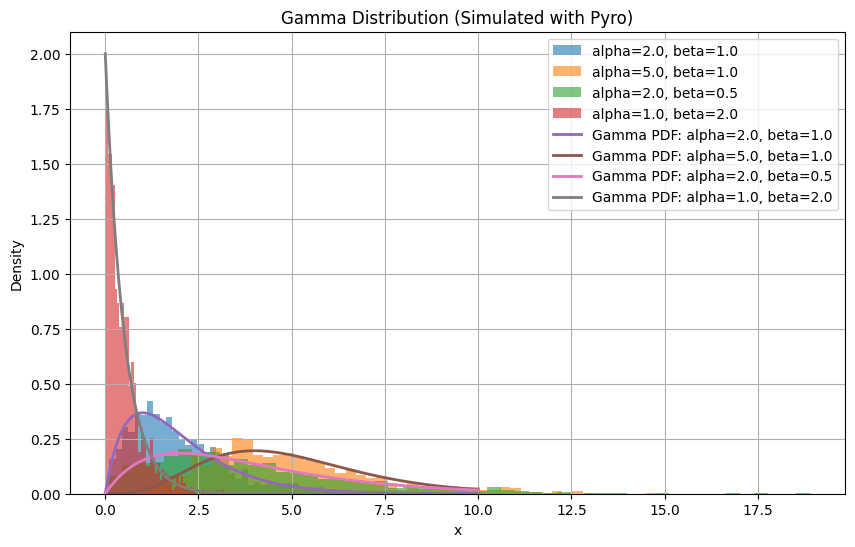

In [4]:
def gamma_sample(alpha, beta, size=1000):
    x = pyro.sample("x", dist.Gamma(concentration=alpha, rate=beta).expand([size]))
    return x

params = [
    (2.0, 1.0),   # Shape (alpha) = 2, Rate (beta) = 1
    (5.0, 1.0),   # Shape (alpha) = 5, Rate (beta) = 1
    (2.0, 0.5),   # Shape (alpha) = 2, Rate (beta) = 0.5 (higher variance)
    (1.0, 2.0),   # Shape (alpha) = 1, Rate (beta) = 2 (skewed to the right)
]

x = np.linspace(0, 10, 1000)  

plt.figure(figsize=(10, 6))
for alpha, beta in params:
    samples = gamma_sample(torch.tensor(alpha), torch.tensor(beta), size=1000).numpy()
    
    plt.hist(samples, bins=50, density=True, alpha=0.6, label=f"alpha={alpha}, beta={beta}")

for alpha, beta in params:
    y = dist.Gamma(concentration=alpha, rate=beta).log_prob(torch.tensor(x)).exp().numpy()
    plt.plot(x, y, label=f"Gamma PDF: alpha={alpha}, beta={beta}", linewidth=2)

plt.title('Gamma Distribution (Simulated with Pyro)')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
distance_model = DistanceCausalModel(
    **subset, categorical_levels=zoning_dataset_read.categorical_levels
)

with pyro.poutine.trace() as tr:
    distance_model(**subset)

print(tr.trace.nodes.keys())   

odict_keys(['data', 'year', 'month', 'zone_id', 'neighborhood_id', 'ward_id', 'past_reform', 'limit_con', 'sigma_distance_to_transit', 'weights_categorical_zone_id_distance_to_transit', 'mean_outcome_prediction_distance_to_transit', 'distance_to_transit', 'sigma_parcel_area', 'bias_continuous_distance_to_transit_parcel_area', 'weight_continuous_distance_to_transit_parcel_area_', 'weights_categorical_zone_id_parcel_area', 'weights_categorical_neighborhood_id_parcel_area', 'mean_outcome_prediction_parcel_area', 'parcel_area', 'sigma_housing_units', 'bias_continuous_limit_con_housing_units', 'weight_continuous_limit_con_housing_units_', 'bias_continuous_parcel_area_housing_units', 'weight_continuous_parcel_area_housing_units_', 'bias_continuous_distance_to_transit_housing_units', 'weight_continuous_distance_to_transit_housing_units_', 'weights_categorical_year_housing_units', 'weights_categorical_month_housing_units', 'weights_categorical_zone_id_housing_units', 'weights_categorical_neigh

[iteration 0001] loss: 5919.1865
[iteration 0050] loss: 5498.0386
[iteration 0100] loss: 5465.4272


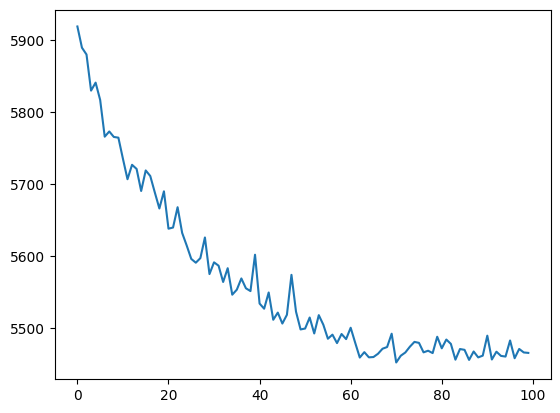

In [6]:
# smoke test inference

pyro.clear_param_store()
guide = run_svi_inference(
    distance_model, n_steps=100, lr=0.03, vi_family=AutoDiagonalNormal, **subset
)

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


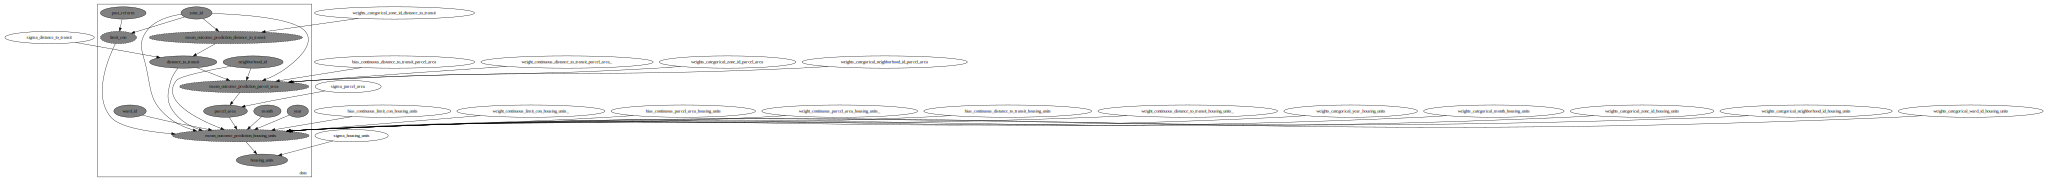

In [7]:
pyro.render_model(
    lambda: distance_model(**subset),
    filename="units_causal_model.png",
    render_deterministic=True,
)

In [8]:
with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit_con": torch.tensor(1.0)}):
        with pyro.poutine.trace() as tr_do:
            distance_model(**subset)

print(tr_do.trace.nodes["limit_con"]["value"].shape)

assert tr_do.trace.nodes["limit_con"]["value"].shape == torch.Size([2, 1, 1, 1, 302])


value = tr_do.trace.nodes["limit_con"]["value"]

with mwc:
    observed_limit = gather(
        value, IndexSet(**{"limit_con": {0}}), event_dims=0
    )
    intervened_limit  = gather(
        value, IndexSet(**{"limit_con": {1}}), event_dims=0
    )


print(intervened_limit)

torch.Size([2, 1, 1, 1, 302])
tensor([[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          

[iteration 0001] loss: 3614.8960


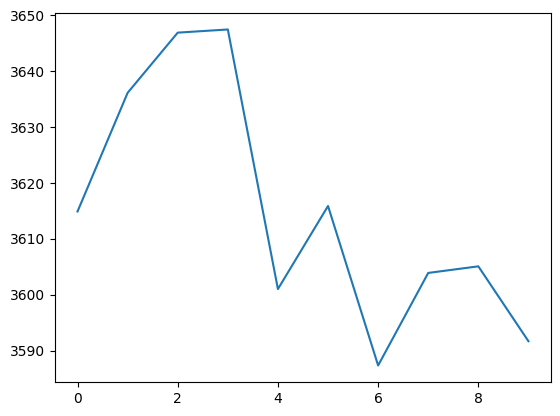

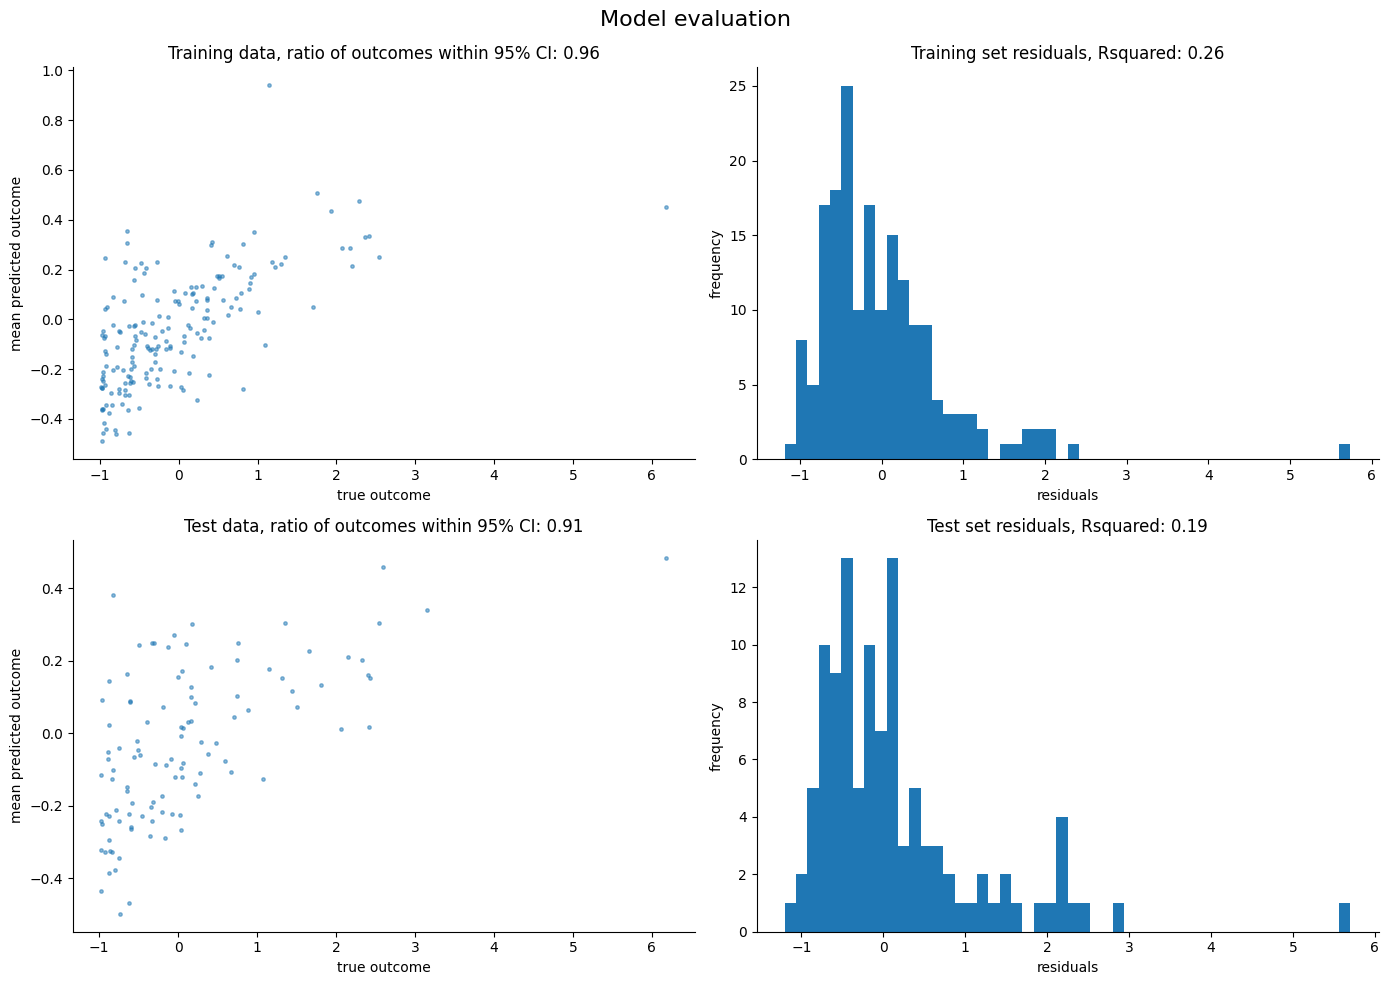

{'mae_train': 0.5628239512443542,
 'mae_test': 0.6837726831436157,
 'rsquared_train': tensor(0.2551),
 'rsquared_test': tensor(0.1901),
 'coverage_train': 0.9558011293411255,
 'coverage_test': 0.9082568883895874}

In [9]:
pyro.clear_param_store()

train_loader, test_loader, categorical_levels = prep_data_for_test(train_size=0.6)

kwargs = {
    "categorical": [
        "year",
        "month",
        "zone_id",
        "neighborhood_id",
        "ward_id",
        "past_reform",
    ],
    "continuous": {"limit_con", "parcel_area", "distance_to_transit"},
    "outcome": "housing_units",
}

test_performance(
    distance_model,
    kwargs,
    train_loader,
    test_loader,
    categorical_levels,
    n_steps=n_steps,
    plot=True,
    is_class=False,
)

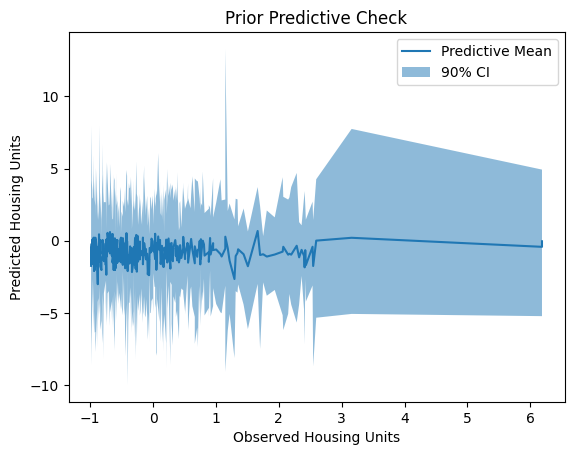

In [10]:
# prior_predictive_check


subset_no_outcome = copy.deepcopy(subset)
subset_no_outcome['outcome'] = None

prior_predictive = Predictive(distance_model, num_samples=num_samples)

prior_samples = prior_predictive(**subset_no_outcome)

samples_outcome = prior_samples['housing_units']
pred_means = samples_outcome.mean(axis = 0)
pred_low = samples_outcome.quantile(0.05, axis =0)
pred_high = samples_outcome.quantile(0.95, axis =0)


prior_df = pd.DataFrame(
    {
        "housing_units": subset["outcome"],
        "pred_means": pred_means,
        "pred_low": pred_low,
        "pred_high": pred_high,
    }
)

#sort priod_df by housing_units
prior_df = prior_df.sort_values(by="housing_units")


plt.plot(prior_df["housing_units"], prior_df["pred_means"], label="Predictive Mean")
plt.fill_between(
    prior_df["housing_units"],
    prior_df["pred_low"],
    prior_df["pred_high"],
    alpha=0.5,
    label="90% CI",
)
plt.xlabel("Observed Housing Units")
plt.ylabel("Predicted Housing Units")
plt.title("Prior Predictive Check")
plt.legend()
plt.show()



[iteration 0001] loss: 5882.6006
[iteration 0050] loss: 5750.0503
[iteration 0100] loss: 5557.1074
[iteration 0150] loss: 5593.6670
[iteration 0200] loss: 5520.8481
[iteration 0250] loss: 5505.3945
[iteration 0300] loss: 5490.8999
[iteration 0350] loss: 5499.5801
[iteration 0400] loss: 5504.1978
[iteration 0450] loss: 5490.1860
[iteration 0500] loss: 5507.2856
[iteration 0550] loss: 5497.7271
[iteration 0600] loss: 5563.4824
[iteration 0650] loss: 5499.1182
[iteration 0700] loss: 5479.7998
[iteration 0750] loss: 5510.6768
[iteration 0800] loss: 5489.5225
[iteration 0850] loss: 5475.4722
[iteration 0900] loss: 5496.6841
[iteration 0950] loss: 5527.1968
[iteration 1000] loss: 5487.2373
[iteration 1050] loss: 5613.2476
[iteration 1100] loss: 5618.3423
[iteration 1150] loss: 5521.3535
[iteration 1200] loss: 5508.1499
[iteration 1250] loss: 5519.9629
[iteration 1300] loss: 5588.4844
[iteration 1350] loss: 5494.9141
[iteration 1400] loss: 5559.5454
[iteration 1450] loss: 5503.2944
[iteration

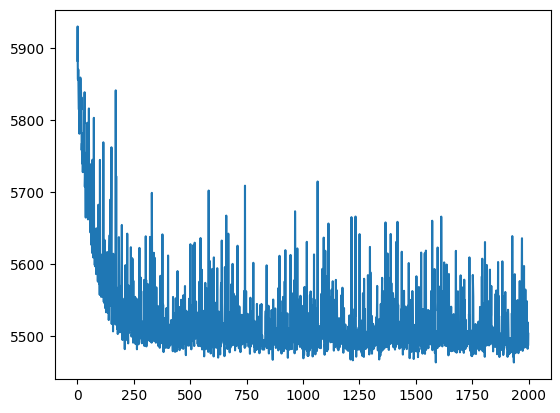

In [12]:
# inference prior to intervention and prediction
pyro.clear_param_store()
guide = run_svi_inference(
    distance_model, n_steps=2000, lr=0.01,  **subset
)


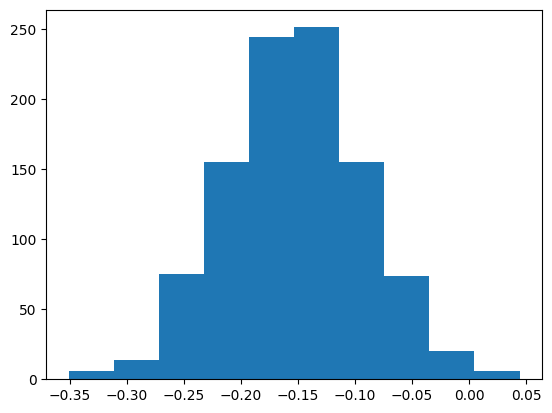

In [22]:
predictive = Predictive(model=distance_model, guide=guide, num_samples=1000, parallel = True)

samples = predictive(**subset_no_outcome)

plt.hist(samples['weight_continuous_limit_con_housing_units_'].squeeze().detach().numpy())
plt.show()

In [23]:
# serialized_guide = dill.dumps(guide)
# file_path = os.path.join(
#     root, "data/minneapolis/guides", f"distance_model_guide.pkl"
# )
# with open(file_path, "wb") as file:
#             file.write(serialized_guide)

# param_path = os.path.join(
#     root,  "data/minneapolis/guides", "distance_model_params.pth")

# pyro.get_param_store().save(param_path)




In [13]:
predictive = Predictive(model=distance_model, guide=guide, num_samples=num_samples)

with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit_con": (torch.tensor(1.0), torch.tensor(0.0))}):
        samples = predictive(**subset_no_outcome)

print(samples["limit_con"].shape)
print(samples["housing_units"].shape)

assert samples["limit_con"].shape == torch.Size([num_samples, 2, 1, 1, 1, 302])
assert samples["housing_units"].shape == torch.Size([num_samples, 2, 1, 1, 1, 302])

torch.Size([10, 2, 1, 1, 1, 302])
torch.Size([10, 2, 1, 1, 1, 302])


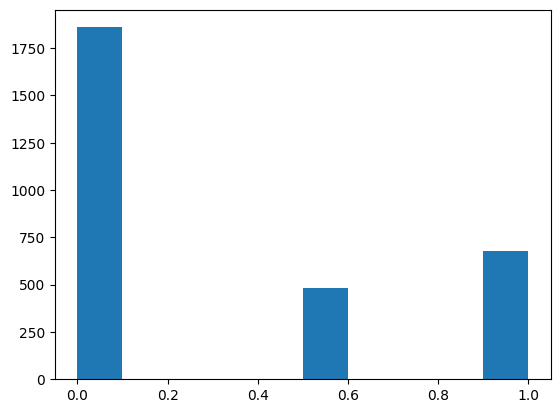

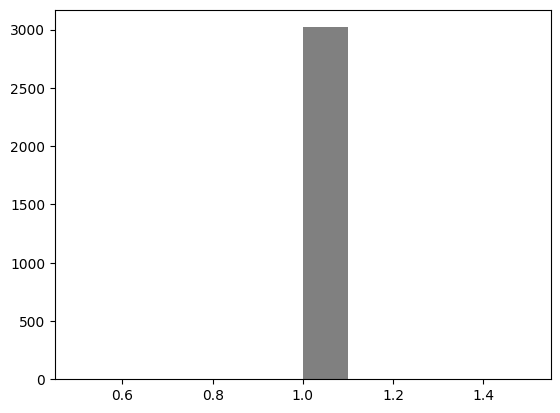

In [14]:
with mwc:

    factual_limit_con = gather(
        samples["limit_con"], IndexSet(**{"limit_con": {0}}), event_dims=0
    )
    counterfactual_limit_con = gather(
        samples["limit_con"], IndexSet(**{"limit_con": {1}}), event_dims=0
    )

    factual_housing_units = gather(
        samples["housing_units"], IndexSet(**{"limit_con": {0}}), event_dims=0
    )

    counterfactual_housing_units = gather(
        samples["housing_units"], IndexSet(**{"limit_con": {1}}), event_dims=0
    )


plt.hist(factual_limit_con.flatten())
plt.show()
plt.hist(counterfactual_limit_con.flatten(), color="grey")
plt.show()

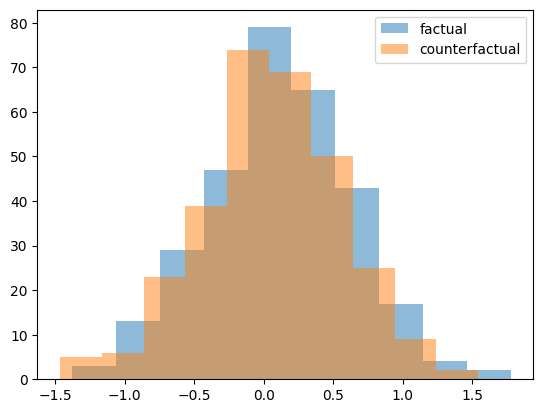

In [17]:
factual_housing_units_means = factual_housing_units.mean(axis=0).flatten().detach()
factual_housing_units_low = (
    factual_housing_units.quantile(0.05, axis=0).flatten().detach()
)
factual_housing_units_high = (
    factual_housing_units.quantile(0.95, axis=0).flatten().detach()
)

counterfactual_housing_units_means = (
    counterfactual_housing_units.mean(axis=0).flatten().detach()
)
counterfactual_housing_units_low = (
    counterfactual_housing_units.quantile(0.05, axis=0).flatten().detach()
)
counterfactual_housing_units_high = (
    counterfactual_housing_units.quantile(0.95, axis=0).flatten().detach()
)

#TODO consider a different outcome distro
#plt.hist(data['continuous']['housing_units'], alpha=0.5, label="data")
plt.hist(factual_housing_units_means, alpha=0.5, label="factual")
plt.hist(counterfactual_housing_units_means, alpha=0.5, label="counterfactual")
plt.legend()
plt.show()

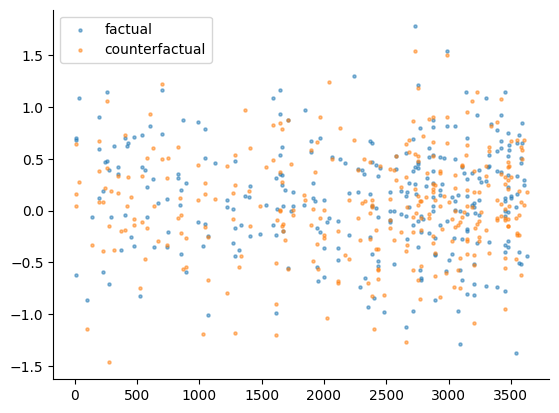

In [18]:
plt.scatter(
    x=data["categorical"]["day"].numpy(),
    y=factual_housing_units_means,
    s=5,
    alpha=0.5,
    label="factual",
)
plt.scatter(
    x=data["categorical"]["day"].numpy(),
    y=counterfactual_housing_units_means,
    s=5,
    alpha=0.5,
    label="counterfactual",
)
plt.legend()
sns.despine()
plt.show()

(302,)


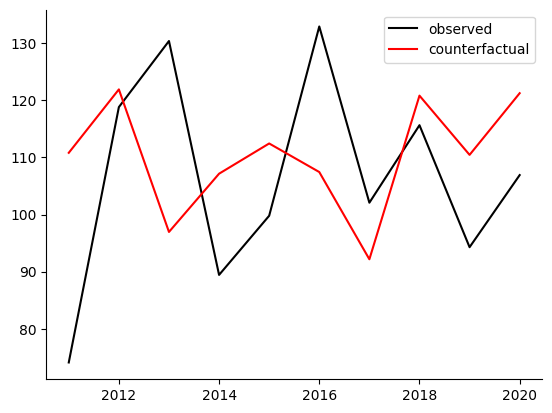

elapsed time since notebook started: 176.4923231601715


In [21]:
year = (subset["categorical"]["year"] + 2011).numpy()
day = data["categorical"]["day"].numpy()
print(day.shape)


def destandardize_housing_units(column):
    mean = zoning_dataset_read.standardization_dictionary["housing_units"]["mean"]
    std = zoning_dataset_read.standardization_dictionary["housing_units"]["std"]

    return (column * std + mean).round()


observed_df = pd.DataFrame(
    {
        "year": year,
        "day": day,
        "observed_housing_units": destandardize_housing_units(prior_df["housing_units"]),
    }
)


observed_df_by_year = observed_df.groupby("year").mean().reset_index()

counterfactual_df = pd.DataFrame(
    {
        "year": year,
        "day": day,
        "counterfactual_housing_units_mean": destandardize_housing_units(
            counterfactual_housing_units_means
        ),
        "counterfactual_housing_units_low": destandardize_housing_units(
            counterfactual_housing_units_low
        ),
        "counterfactual_housing_units_high": destandardize_housing_units(
            counterfactual_housing_units_high
        ),
    }
)


counterfactual_df_by_year = counterfactual_df.groupby("year").mean().reset_index()

plt.plot(
    observed_df_by_year["year"],
    observed_df_by_year["observed_housing_units"],
    color="black",
    label="observed",
)
plt.plot(
    observed_df_by_year["year"],
    counterfactual_df_by_year["counterfactual_housing_units_mean"],
    color="red",
    label="counterfactual",
)
plt.legend()
sns.despine()
plt.show()

end = time.time()
print(f"elapsed time since notebook started: {end - start}")